# Plan
- [x] load data ~ 30 min
- [x] Make prediction ~ 30 min
- [x] Train model ~ 10 min
    - [x] Fix model ~ 40 min
- [x] Submit work ~ 5 min

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T 
from torch.utils.data import Dataset, DataLoader

from PIL import Image 

from efficientnet_pytorch import EfficientNet

In [3]:
'''
Global variables
'''
EPOCHS = 10
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda


## Data preparation 
Preparing files paths,  
Remap and translate to numbers our target values

In [4]:
data_path = '../data'
path_20 = data_path + '/2020/128x128'
path_19 = data_path + '/2019/128x128'

In [5]:
df_19 = pd.read_csv(path_19 + '/train.csv')
df_20 = pd.read_csv(path_20 + '/train.csv')

df_20_test = pd.read_csv(path_20 + '/test.csv')

In [6]:
df_19 = df_19[['image_name', 'diagnosis']]
df_20 = df_20[['image_name', 'diagnosis']]
s
df_20_test = df_20_test[['image_name']]

### Target values matching

In [7]:
unique_targets_19 = df_19['diagnosis'].unique()
unique_targets_20 = df_20['diagnosis'].unique()

print('2019 targets:\n',unique_targets_19, '\n')
print('2020 targets:\n',unique_targets_20)

2019 targets:
 ['NV' 'MEL' 'BKL' 'DF' 'SCC' 'BCC' 'VASC' 'AK'] 

2020 targets:
 ['unknown' 'nevus' 'melanoma' 'seborrheic keratosis' 'lentigo NOS'
 'lichenoid keratosis' 'solar lentigo' 'cafe-au-lait macule'
 'atypical melanocytic proliferation']


In [9]:
remap = {
    'atypical melanocytic proliferation':'UN',
    'cafe-au-lait macule':'UN',
    'solar lentigo':'BLK',
    'lichenoid keratosis':'BLK',
    'lentigo NOS':'BLK',
    'seborrheic keratosis':'BLK',
    'melanoma':'MEL',
    'nevus':'NV',
    'unknown':'UN'}

df_20 = df_20.replace(remap)

In [10]:
total_targets = np.unique(np.append(df_19['diagnosis'].unique(), df_20['diagnosis'].unique()))
print('Total:',total_targets)

remap = dict(zip(total_targets, np.arange(len(total_targets))))

df_20 = df_20.replace(remap)
df_19 = df_19.replace(remap)

replaced_targets = np.unique(np.append(df_19['diagnosis'].unique(), df_20['diagnosis'].unique()))
print('Replaced:', replaced_targets)
print('Remap:\n',remap)

Total: ['AK' 'BCC' 'BKL' 'BLK' 'DF' 'MEL' 'NV' 'SCC' 'UN' 'VASC']
Replaced: [0 1 2 3 4 5 6 7 8 9]
Remap:
 {'AK': 0, 'BCC': 1, 'BKL': 2, 'BLK': 3, 'DF': 4, 'MEL': 5, 'NV': 6, 'SCC': 7, 'UN': 8, 'VASC': 9}


### Preparing files paths 

In [11]:
df_19['image_name'] = [path_19+'/train/'+name+'.jpg' for name in df_19['image_name']]
df_20['image_name'] = [path_20+'/train/'+name+'.jpg' for name in df_20['image_name']]

df_20_test['image_name'] = [path_20+'/test/'+name+'.jpg' for name in df_20_test['image_name']]

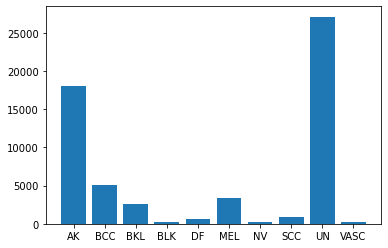

In [12]:
mega_df = df_19.append(df_20)
stats = {l:(mega_df['diagnosis'] == l).sum() for l in mega_df['diagnosis'].unique()}

plt.bar(total_targets, [v for _,v in stats.items()])
plt.show()

### Make Dataset

In [13]:
class DatasetISIC(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None, isTest=False):
        self.df = df
        self.transform = transform
        self.isTest = isTest
        
    def __getitem__(self, idx):
        if self.isTest: return self._get_test_item(idx)
            
        path, target = self.df.iloc[idx]
        
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return self.df.shape[0]
    
    def _get_test_item(self, idx):
        path = self.df.iloc[idx][0]
        
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        return img

### Transformations

In [14]:
transform = T.Compose([
    T.Resize(44),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

### Make a DataLoader

In [15]:
dataset = DatasetISIC(mega_df, transform)
loader = DataLoader(dataset, batch_size=batch_size, num_workers=12)

## Make a model

In [16]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=10)

Loaded pretrained weights for efficientnet-b0


In [17]:
# Model reshaping
in_features = model._fc.in_features
out_features = model._fc.out_features

model._fc = nn.Sequential(
    nn.Linear(in_features, out_features),
    nn.Sigmoid())

### Train the model

In [18]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        # set model to train mode
        model.train()
        # make predictions
        yhat = model(x)
        # computes loss
        loss = loss_fn(yhat, y)
        # computes gradients
        loss.backward()
        # updats parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

In [19]:
# Preapering to training
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

train_step = make_train_step(model, loss_fn, optimizer)

In [20]:
# Training loop
for epoch in range(EPOCHS):
    running_loss = []
    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device) 
        batch_y = batch_y.to(device) 
         
        loss = train_step(batch_x, batch_y)
        running_loss.append(loss)
        
    print('[{}/{}] loss: {:.2f}'
          .format(epoch+1, EPOCHS, np.mean(running_loss)))

[1/25] loss: 2.31
[2/25] loss: 2.29
[3/25] loss: 2.27
[4/25] loss: 2.25
[5/25] loss: 2.23
[6/25] loss: 2.21
[7/25] loss: 2.20
[8/25] loss: 2.19
[9/25] loss: 2.17
[10/25] loss: 2.16
[11/25] loss: 2.15
[12/25] loss: 2.14
[13/25] loss: 2.13
[14/25] loss: 2.13
[15/25] loss: 2.12
[16/25] loss: 2.11
[17/25] loss: 2.10
[18/25] loss: 2.09
[19/25] loss: 2.09
[20/25] loss: 2.08
[21/25] loss: 2.08
[22/25] loss: 2.07
[23/25] loss: 2.06
[24/25] loss: 2.06
[25/25] loss: 2.05


## Make a prediction

In [21]:
dataset_test = DatasetISIC(df_20_test, transform, isTest=True)
loader_test = DataLoader(dataset_test, batch_size=64, num_workers=12)

In [22]:
model.eval()
predictions = []

for batch_x in loader_test:
    batch_x = batch_x.to(device)
    output = model(batch_x)
        
    predictions.append(output.detach().cpu().numpy())
    

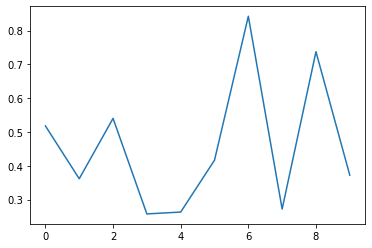

In [34]:
plt.plot(predictions[0][6])

In [23]:
def plot_predictions(preds):
    import seaborn as sns
    fig, ax = plt.subplots(figsize=(6,3), dpi=120)
    sns.distplot(preds, hist_kws={
                     'rwidth': 0.75,
                     'edgecolor': 'black',
                     'alpha': 0.3
                 }, color='#1B9CC2')
    ax.set_title('Final Predictions')
    plt.show()

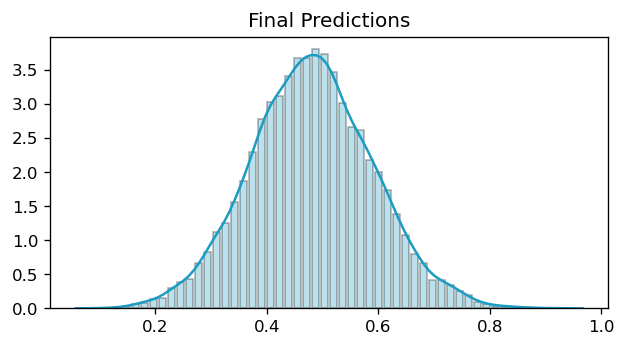

In [24]:
final = []
for pred in predictions:
    final += list(pred[:,5])
    
plot_predictions(final)

In [23]:
final_submission = pd.read_csv(path_20 + '/sample_submission.csv')
final_submission['target'] = final
final_submission.to_csv('final_submission.csv', index=False)